In [1]:
import torch
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt

print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS (Metal Performance Shader) built? {torch.backends.mps.is_built()}")
print(f"Is MPS available? {torch.backends.mps.is_available()}")

# Set the device      
device = "mps" if torch.backends.mps.is_available() else "cpu"
print(f"Using device: {device}")

/Users/abhishek/Machine_learning/Projects/Neural_style_transfer/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


PyTorch version: 1.13.0.dev20220604
Is MPS (Metal Performance Shader) built? True
Is MPS available? True
Using device: mps


In [2]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

/Users/abhishek/Machine_learning/Projects/Neural_style_transfer/env/lib/python3.8/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: dlopen(/Users/abhishek/Machine_learning/Projects/Neural_style_transfer/env/lib/python3.8/site-packages/torchvision/image.so, 0x0006): Library not loaded: @rpath/libpng16.16.dylib
  Referenced from: /Users/abhishek/Machine_learning/Projects/Neural_style_transfer/env/lib/python3.8/site-packages/torchvision/image.so
  Reason: tried: '/Users/abhishek/Machine_learning/Projects/Neural_style_transfer/env/lib/python3.8/lib-dynload/../../libpng16.16.dylib' (no such file), '/Users/abhishek/Machine_learning/Projects/Neural_style_transfer/env/bin/../lib/libpng16.16.dylib' (no such file), '/usr/local/lib/libpng16.16.dylib' (no such file), '/usr/lib/libpng16.16.dylib' (no such file)
  warn(f"Failed to load image Python extension: {e}")


In [3]:
imsize = 512 if torch.backends.mps.is_available() else 128

loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor()])

def image_loader(image_name):
    image = Image.open(image_name)
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [4]:
content_img = image_loader("images/content/content3.jpeg")
style_img = image_loader("images/style/style6.jpeg")

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

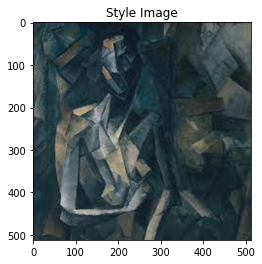

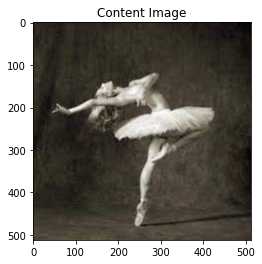

In [5]:
unloader = transforms.ToPILImage()

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()
    image = image.squeeze(0)
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
plt.figure()
imshow(style_img, title="Style Image")

plt.figure()
imshow(content_img, title="Content Image")

In [6]:
class ContentLoss(nn.Module):
    
    def __init__(self, target):
        super(ContentLoss, self).__init__()
        self.target = target.detach()
        
    def forward(self, input):
        
        self.loss = F.mse_loss(input, self.target)
        return input

In [7]:
def gram_matrix(input):
    a, b, c, d = input.size()
    features = input.view(a * b, c * d)
    G = torch.mm(features, features.t())
    return G.div(a * b * c * d)

In [8]:
class StyleLoss(nn.Module):
    
    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()
        
    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

In [9]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

/Users/abhishek/Machine_learning/Projects/Neural_style_transfer/env/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/abhishek/Machine_learning/Projects/Neural_style_transfer/env/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [10]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)
    
    def forward(self, img):
        return (img - self.mean) / self.std

In [11]:
content_layers_default = ["conv_4"]
style_layers_default = ["conv_1", "conv_2", "conv_3", "conv_4", "conv_5"]

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                              style_img, content_img, 
                              content_layers=content_layers_default,
                              style_layers=style_layers_default):
    normalization = Normalization(normalization_mean, normalization_std).to(device)
    
    content_losses = []
    style_losses = []
    
    model = nn.Sequential(normalization)
    
    i = 0
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = f"conv_{i}"
        elif isinstance(layer, nn.ReLU):
            name = f"relu_{i}"
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = f"pool_{i}"
        elif isinstance(layer, nn.BatchNorm2d):
            name = f"bn_{i}"
        else:
            raise RuntimeError(f"Unrecognized layer: {layer.__class__.__name__}")
            
        model.add_module(name, layer)
        
        if name in content_layers:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module(f"content_loss_{i}", content_loss)
            content_losses.append(content_loss)
            
        if name in style_layers:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module(f"style_loss_{i}", style_loss)
            style_losses.append(style_loss)
        
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break
    
    model = model[:(i + 1)]
    
    return model, style_losses, content_losses

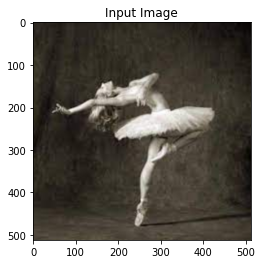

In [12]:
input_img = content_img.clone()
# input_img = torch.randn(content_img.data.size(), device=device)

plt.figure()
imshow(input_img, title="Input Image")

In [13]:
def get_input_optimizer(input_img):
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [14]:
def run_style_transfer(cnn, normalization_mean, normalization_std, 
                      content_img, style_img, input_img, num_steps=300, 
                      style_weight=1000000, content_weight=10):
    """Run the style transfer"""
    print("Building the style transfer model..")
    model, style_losses, content_losses = get_style_model_and_losses(cnn, 
        normalization_mean, normalization_std, style_img, content_img)
    
    input_img.requires_grad_(True)
    model.requires_grad_(False)
    
    optimizer = get_input_optimizer(input_img)
    
    print("Optimizing..")
    run = [0]
    while run[0] <= num_steps:
        
        def closure():
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += sl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print(f"run {run}")
                print("Style Loss: {:4f}; Content Loss: {:4f};".format(
                style_score.item(), content_score.item()))
                print()

            return style_score + content_score
        
        optimizer.step(closure)
    
    with torch.no_grad():
        input_img.clamp_(0, 1)
    
    return input_img

Building the style transfer model..


/var/folders/mr/h8kbzcd56ld_p7f6cxrn0ykw0000gn/T/ipykernel_35639/1078408938.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.mean = torch.tensor(mean).view(-1, 1, 1)
/var/folders/mr/h8kbzcd56ld_p7f6cxrn0ykw0000gn/T/ipykernel_35639/1078408938.py:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.std = torch.tensor(std).view(-1, 1, 1)


Optimizing..
run [50]
Style Loss: 4.878994; Content Loss: 0.000010;

run [100]
Style Loss: 1.131390; Content Loss: 0.000002;

run [150]
Style Loss: 0.661690; Content Loss: 0.000001;

run [200]
Style Loss: 0.409004; Content Loss: 0.000000;

run [250]
Style Loss: 0.250398; Content Loss: 0.000000;

run [300]
Style Loss: 0.158238; Content Loss: 0.000000;



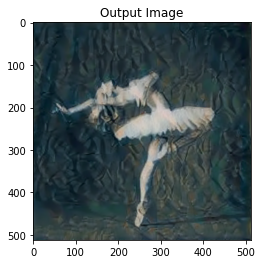

In [15]:
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                           content_img, style_img, input_img)

plt.figure()
imshow(output, title="Output Image")

plt.ioff()
plt.show()

In [16]:
from torchvision.utils import save_image
save_image(output, "images/generated/pyt_gen1.jpeg")